In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import os, pathlib, glob, random
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix
import scipy
from scipy import io

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
batch_size = 32
output_nodes = 2
learning_rate = 0.003

In [4]:
import os
import random
import scipy.io
import numpy as np
from torch.utils.data import Dataset, DataLoader

# Paths for both datasets
train_data_paths = [
    r"/kaggle/input/mfcc-t3-singfox/MFCC_T3/mfcc/train" #,  # Language 1
    # r"/kaggle/input/singfox-t2-gfcc-icassp/GFCC_T2/gfcc/train"   # Language 2
]
validation_data_paths = [
    r"/kaggle/input/mfcc-t3-singfox/MFCC_T3/mfcc/val" #,
    # r"/kaggle/input/singfox-t2-gfcc-icassp/GFCC_T2/gfcc/val"
]
testing_data_paths = [
    r"/kaggle/input/mfcc-t3-singfox/MFCC_T3/mfcc/test" #,
    # r"/kaggle/input/singfox-t2-gfcc-icassp/GFCC_T2/gfcc/test"
]

class MixedPtDataset(Dataset):
    def __init__(self, directories):
        """Load features from multiple directories."""
        self.files = []
        self.class_to_idx = {}

        for directory in directories:
            classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
            
            # Assign class indices if not already assigned
            for c in classes:
                if c not in self.class_to_idx:
                    self.class_to_idx[c] = len(self.class_to_idx)

            for c in classes:
                c_dir = os.path.join(directory, c)
                c_files = [(os.path.join(c_dir, f), self.class_to_idx[c]) for f in os.listdir(c_dir)]
                self.files.extend(c_files)

        random.shuffle(self.files)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        filepath, label = self.files[idx]
        try:
            mat_vals = scipy.io.loadmat(filepath)
            data = mat_vals['final'].T
            max_len = 200
            if max_len > data.shape[0]:
                pad_width = max_len - data.shape[0]
                data = np.pad(data, pad_width=((0, pad_width), (0, 0)), mode='constant')
            else:
                data = data[:max_len, :]
        except Exception as e:
            print(f"Error loading file {filepath}: {str(e)}")
            return None
        return data, label

# Combine both datasets
train_dataset = MixedPtDataset(train_data_paths)
val_dataset = MixedPtDataset(validation_data_paths)
test_dataset = MixedPtDataset(testing_data_paths)

class PtDataLoader(DataLoader):
    def __init__(self, directories, batch_size, shuffle=True):
        dataset = MixedPtDataset(directories)
        super().__init__(dataset, batch_size=batch_size, shuffle=shuffle)

# Load mixed datasets
batch_size = 32
train_dataloader = PtDataLoader(directories=train_data_paths, batch_size=batch_size)
val_dataloader = PtDataLoader(directories=validation_data_paths, batch_size=batch_size)
test_dataloader = PtDataLoader(directories=testing_data_paths, batch_size=batch_size)

train_count = len(train_dataset)
val_count = len(val_dataset)
test_count = len(test_dataset)

print(f"Training samples: {train_count}\nValidation samples: {val_count}\nTesting samples: {test_count}")

Training samples: 17584
Validation samples: 3768
Testing samples: 3768


In [5]:
print(train_count)
print(test_count)
print(val_count)

17584
3768
3768


In [6]:
import torch
from torch import nn
from torch.nn import Parameter
import torch.nn.functional as F

In [7]:
# Define the parameters
input_size = 20
hidden_size = 256
num_layers = 2
num_classes = 2
# drop_amount = 0.25  # You can choose an appropriate dropout rate

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

In [9]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import os, pathlib, glob, random
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import confusion_matrix
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from datasets import load_dataset
from transformers.models.whisper.modeling_whisper import WhisperModel, WhisperEncoder
from transformers.models.whisper.configuration_whisper import WhisperConfig
from typing import Optional, Tuple, Union
import torch
import librosa 
import matplotlib.pyplot as plt
import numpy as np
import os, glob, pickle
import scipy.io as sio
from tqdm import tqdm
import multiprocessing as mp 
import torch.optim as optim

2025-07-03 14:14:42.898248: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751552083.073877      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751552083.126179      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [10]:
# BiLSTM

In [11]:
drop_amount = 0.255

class BiLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiLSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(p=drop_amount)
        self.fc = nn.Linear(hidden_size*2, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device=x.device, dtype=torch.double)
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device=x.device, dtype=torch.double)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        # Extract the output of the last time step from both directions
        last_hidden_state = torch.cat((out[:, -1, :self.hidden_size], out[:, 0, self.hidden_size:]), dim=1)
        output = self.fc(last_hidden_state)
        return output

In [12]:
batch_size = 32
output_nodes = 2
learning_rate = 0.003

In [13]:
model = BiLSTMClassifier(input_size, hidden_size, num_layers, num_classes)
model.to(device, dtype=torch.double)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print(model)

BiLSTMClassifier(
  (lstm): LSTM(20, 256, num_layers=2, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.255, inplace=False)
  (fc): Linear(in_features=512, out_features=2, bias=True)
)


In [14]:
print(model)

BiLSTMClassifier(
  (lstm): LSTM(20, 256, num_layers=2, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.255, inplace=False)
  (fc): Linear(in_features=512, out_features=2, bias=True)
)


In [15]:
from tqdm import tqdm
import torch
from torch.autograd import Variable

# Model training and testing
n_total_steps = len(train_dataloader)
train_accuracy_list = []
train_loss_list = []
val_accuracy_list = []
max_acc = 0
num_epochs = 20
pred_labels = []
act_labels = []

for epoch in range(num_epochs):
    
    # Training phase
    model.train()
    train_accuracy = 0.0
    train_loss = 0.0
    
    print(f"\nEpoch {epoch + 1}/{num_epochs} - Training...")
    
    # Use tqdm for progress bar in training loop
    for batch_idx, (images, labels) in enumerate(tqdm(train_dataloader, desc="Training Batches")):
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.cpu().data * images.size(0)
        _, prediction = torch.max(outputs.data, 1)
        train_accuracy += int(torch.sum(prediction == labels.data))
    
    train_accuracy = train_accuracy / train_count
    train_loss = train_loss / train_count
    
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(train_loss)

    # Validation phase
    model.eval()
    val_accuracy = 0.0
    pred = []
    lab = []
    
    print(f"Epoch {epoch + 1}/{num_epochs} - Validation...")
    
    # Use tqdm for progress bar in validation loop
    for i, (images, labels) in enumerate(tqdm(val_dataloader, desc="Validation Batches")):
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())
        
        outputs = model(images)
        _, prediction = torch.max(outputs.data, 1)
        val_accuracy += int(torch.sum(prediction == labels.data))
        
        pred.extend(prediction.tolist())
        lab.extend(labels.tolist())
    
    val_accuracy = val_accuracy / val_count
    val_accuracy_list.append(val_accuracy)
    
    # Save best model
    if max_acc < val_accuracy:
        max_acc = val_accuracy
        pred_labels = pred
        actual_labels = lab
        torch.save(model, "best_accuracy_model_BiLSTM.pth")
    
    print(f'Epoch: {epoch + 1}/{num_epochs}   '
          f'Train Loss: {train_loss:.4f}   '
          f'Train Accuracy: {train_accuracy:.4f}   '
          f'Validation Accuracy: {val_accuracy:.4f}')

print('\nMaximum Validation Accuracy:', max_acc)
print('Finished Training and Validation')



Epoch 1/20 - Training...


Training Batches: 100%|██████████| 550/550 [02:24<00:00,  3.81it/s]


Epoch 1/20 - Validation...


Validation Batches: 100%|██████████| 118/118 [00:24<00:00,  4.90it/s]


Epoch: 1/20   Train Loss: 0.4897   Train Accuracy: 0.7472   Validation Accuracy: 0.7797

Epoch 2/20 - Training...


Training Batches: 100%|██████████| 550/550 [01:11<00:00,  7.74it/s]


Epoch 2/20 - Validation...


Validation Batches: 100%|██████████| 118/118 [00:08<00:00, 13.41it/s]


Epoch: 2/20   Train Loss: 0.4613   Train Accuracy: 0.7676   Validation Accuracy: 0.7903

Epoch 3/20 - Training...


Training Batches: 100%|██████████| 550/550 [01:10<00:00,  7.79it/s]


Epoch 3/20 - Validation...


Validation Batches: 100%|██████████| 118/118 [00:08<00:00, 13.64it/s]


Epoch: 3/20   Train Loss: 0.4198   Train Accuracy: 0.7989   Validation Accuracy: 0.8047

Epoch 4/20 - Training...


Training Batches: 100%|██████████| 550/550 [01:11<00:00,  7.75it/s]


Epoch 4/20 - Validation...


Validation Batches: 100%|██████████| 118/118 [00:08<00:00, 13.60it/s]


Epoch: 4/20   Train Loss: 0.3951   Train Accuracy: 0.8138   Validation Accuracy: 0.8246

Epoch 5/20 - Training...


Training Batches: 100%|██████████| 550/550 [01:10<00:00,  7.83it/s]


Epoch 5/20 - Validation...


Validation Batches: 100%|██████████| 118/118 [00:09<00:00, 13.10it/s]


Epoch: 5/20   Train Loss: 0.3828   Train Accuracy: 0.8212   Validation Accuracy: 0.8336

Epoch 6/20 - Training...


Training Batches: 100%|██████████| 550/550 [01:10<00:00,  7.77it/s]


Epoch 6/20 - Validation...


Validation Batches: 100%|██████████| 118/118 [00:09<00:00, 12.88it/s]


Epoch: 6/20   Train Loss: 0.3598   Train Accuracy: 0.8300   Validation Accuracy: 0.8373

Epoch 7/20 - Training...


Training Batches: 100%|██████████| 550/550 [01:11<00:00,  7.68it/s]


Epoch 7/20 - Validation...


Validation Batches: 100%|██████████| 118/118 [00:08<00:00, 13.58it/s]


Epoch: 7/20   Train Loss: 0.3403   Train Accuracy: 0.8404   Validation Accuracy: 0.8501

Epoch 8/20 - Training...


Training Batches: 100%|██████████| 550/550 [01:14<00:00,  7.34it/s]


Epoch 8/20 - Validation...


Validation Batches: 100%|██████████| 118/118 [00:09<00:00, 12.00it/s]


Epoch: 8/20   Train Loss: 0.3312   Train Accuracy: 0.8441   Validation Accuracy: 0.8288

Epoch 9/20 - Training...


Training Batches: 100%|██████████| 550/550 [01:14<00:00,  7.35it/s]


Epoch 9/20 - Validation...


Validation Batches: 100%|██████████| 118/118 [00:08<00:00, 13.24it/s]


Epoch: 9/20   Train Loss: 0.3216   Train Accuracy: 0.8484   Validation Accuracy: 0.8511

Epoch 10/20 - Training...


Training Batches: 100%|██████████| 550/550 [01:11<00:00,  7.71it/s]


Epoch 10/20 - Validation...


Validation Batches: 100%|██████████| 118/118 [00:09<00:00, 12.50it/s]


Epoch: 10/20   Train Loss: 0.3070   Train Accuracy: 0.8564   Validation Accuracy: 0.8439

Epoch 11/20 - Training...


Training Batches: 100%|██████████| 550/550 [01:12<00:00,  7.55it/s]


Epoch 11/20 - Validation...


Validation Batches: 100%|██████████| 118/118 [00:09<00:00, 12.73it/s]


Epoch: 11/20   Train Loss: 0.2988   Train Accuracy: 0.8631   Validation Accuracy: 0.8631

Epoch 12/20 - Training...


Training Batches: 100%|██████████| 550/550 [01:11<00:00,  7.68it/s]


Epoch 12/20 - Validation...


Validation Batches: 100%|██████████| 118/118 [00:08<00:00, 13.47it/s]


Epoch: 12/20   Train Loss: 0.2871   Train Accuracy: 0.8673   Validation Accuracy: 0.8567

Epoch 13/20 - Training...


Training Batches: 100%|██████████| 550/550 [01:12<00:00,  7.60it/s]


Epoch 13/20 - Validation...


Validation Batches: 100%|██████████| 118/118 [00:09<00:00, 12.42it/s]


Epoch: 13/20   Train Loss: 0.2789   Train Accuracy: 0.8715   Validation Accuracy: 0.8641

Epoch 14/20 - Training...


Training Batches: 100%|██████████| 550/550 [01:12<00:00,  7.61it/s]


Epoch 14/20 - Validation...


Validation Batches: 100%|██████████| 118/118 [00:09<00:00, 13.10it/s]


Epoch: 14/20   Train Loss: 0.2791   Train Accuracy: 0.8720   Validation Accuracy: 0.8678

Epoch 15/20 - Training...


Training Batches: 100%|██████████| 550/550 [01:11<00:00,  7.66it/s]


Epoch 15/20 - Validation...


Validation Batches: 100%|██████████| 118/118 [00:08<00:00, 13.36it/s]


Epoch: 15/20   Train Loss: 0.2716   Train Accuracy: 0.8743   Validation Accuracy: 0.8458

Epoch 16/20 - Training...


Training Batches: 100%|██████████| 550/550 [01:11<00:00,  7.70it/s]


Epoch 16/20 - Validation...


Validation Batches: 100%|██████████| 118/118 [00:08<00:00, 13.23it/s]


Epoch: 16/20   Train Loss: 0.2698   Train Accuracy: 0.8745   Validation Accuracy: 0.8686

Epoch 17/20 - Training...


Training Batches: 100%|██████████| 550/550 [01:11<00:00,  7.72it/s]


Epoch 17/20 - Validation...


Validation Batches: 100%|██████████| 118/118 [00:09<00:00, 13.01it/s]


Epoch: 17/20   Train Loss: 0.2569   Train Accuracy: 0.8809   Validation Accuracy: 0.8734

Epoch 18/20 - Training...


Training Batches: 100%|██████████| 550/550 [01:12<00:00,  7.55it/s]


Epoch 18/20 - Validation...


Validation Batches: 100%|██████████| 118/118 [00:08<00:00, 13.56it/s]


Epoch: 18/20   Train Loss: 0.2702   Train Accuracy: 0.8764   Validation Accuracy: 0.8410

Epoch 19/20 - Training...


Training Batches: 100%|██████████| 550/550 [01:13<00:00,  7.45it/s]


Epoch 19/20 - Validation...


Validation Batches: 100%|██████████| 118/118 [00:09<00:00, 12.09it/s]


Epoch: 19/20   Train Loss: 0.2532   Train Accuracy: 0.8826   Validation Accuracy: 0.8697

Epoch 20/20 - Training...


Training Batches: 100%|██████████| 550/550 [01:11<00:00,  7.72it/s]


Epoch 20/20 - Validation...


Validation Batches: 100%|██████████| 118/118 [00:08<00:00, 13.19it/s]

Epoch: 20/20   Train Loss: 0.2437   Train Accuracy: 0.8881   Validation Accuracy: 0.8731

Maximum Validation Accuracy: 0.8734076433121019
Finished Training and Validation


In [16]:
# Load the best model
best_model = torch.load("best_accuracy_model_BiLSTM.pth", weights_only=False)

# Put the best_model in evaluation mode
best_model.eval()

# Initialize variables to store results
testing_accuracy = 0.0
pred_labels = []
act_labels = []

# Pass validation data through the best model
for i, (images, labels) in enumerate(test_dataloader):
    if torch.cuda.is_available():
        images = Variable(images.cuda())
        labels = Variable(labels.cuda())
    
    outputs = best_model(images)
    _, prediction = torch.max(outputs.data, 1)
    
    testing_accuracy += int(torch.sum(prediction == labels.data))
    
    pred_labels.extend(prediction.tolist())
    act_labels.extend(labels.tolist())

# Calculate validation accuracy
testing_accuracy = testing_accuracy / len(test_dataloader.dataset)

# Print the validation accuracy
print("testing Accuracy:", testing_accuracy)

testing Accuracy: 0.8755307855626328


Testing Accuracy     : 0.8755
Precision            : 0.8419
Recall               : 0.9232
F1 Score (Macro)     : 0.8753
F1 Score (Micro)     : 0.8755
Hamming Loss         : 0.1245
AUC                  : 0.9449
EER                  : 0.1294 at threshold 0.6140


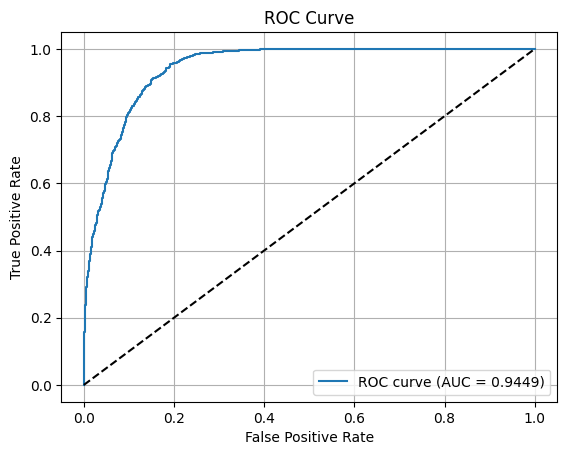

In [17]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_curve, auc, hamming_loss, confusion_matrix, roc_auc_score)
import matplotlib.pyplot as plt
import numpy as np
# Load best model
best_model = torch.load("best_accuracy_model_BiLSTM.pth", weights_only=False)
best_model.eval()

pred_labels = []
act_labels = []
pred_probs = []

# Evaluate
for images, labels in test_dataloader:
    if torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()
    
    with torch.no_grad():
        outputs = best_model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # probability for class 1
        preds = torch.argmax(outputs, dim=1)
    
    pred_labels.extend(preds.cpu().tolist())
    act_labels.extend(labels.cpu().tolist())
    pred_probs.extend(probs.cpu().tolist())

# Convert to NumPy
y_true = np.array(act_labels)
y_pred = np.array(pred_labels)
y_score = np.array(pred_probs)

# Basic Metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_micro = f1_score(y_true, y_pred, average='micro')
hamming = hamming_loss(y_true, y_pred)
conf_mat = confusion_matrix(y_true, y_pred)

# ROC and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

# EER calculation
fnr = 1 - tpr
eer_threshold = thresholds[np.nanargmin(np.absolute(fnr - fpr))]
eer = fpr[np.nanargmin(np.absolute(fnr - fpr))]

# Print all
print(f"Testing Accuracy     : {acc:.4f}")
print(f"Precision            : {prec:.4f}")
print(f"Recall               : {rec:.4f}")
print(f"F1 Score (Macro)     : {f1_macro:.4f}")
print(f"F1 Score (Micro)     : {f1_micro:.4f}")
print(f"Hamming Loss         : {hamming:.4f}")
# print(f"Confusion Matrix     :\n{conf_mat}")
print(f"AUC                  : {roc_auc:.4f}")
print(f"EER                  : {eer:.4f} at threshold {eer_threshold:.4f}")

# Optional: Plot ROC
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

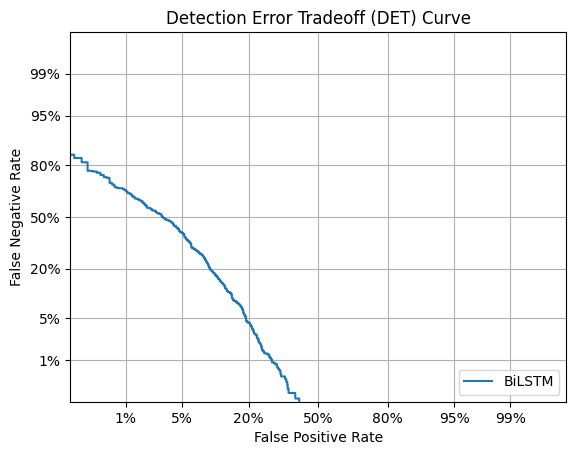

In [18]:
from sklearn.metrics import det_curve, DetCurveDisplay

# Compute DET curve data
fpr_det, fnr_det, det_thresholds = det_curve(y_true, y_score)

# Plot DET curve using Display
import matplotlib.pyplot as plt

disp = DetCurveDisplay(fpr=fpr_det, fnr=fnr_det, estimator_name="BiLSTM")
disp.plot()
plt.title("Detection Error Tradeoff (DET) Curve")
plt.grid(True)
plt.show()


In [19]:
# from sklearn.metrics import det_curve
# import numpy as np

# # Compute DET curve arrays
# fpr_det, fnr_det, det_thresholds = det_curve(y_true, y_score)

# # Display summary
# print("Number of thresholds:", len(det_thresholds))
# for i in range(min(10, len(det_thresholds))):
#     print(f"Thresh ≥ {det_thresholds[i]:.4f}: FPR = {fpr_det[i]:.4f}, FNR = {fnr_det[i]:.4f}")


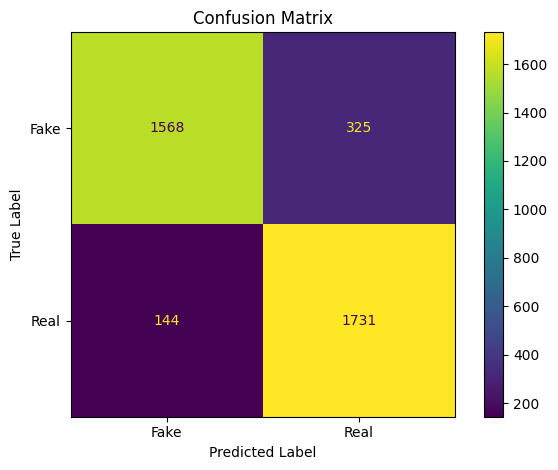

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Set correct class names
class_names = ["Fake", "Real"]  # 0 = Fake, 1 = Real

# Create confusion matrix
cm = confusion_matrix(act_labels, pred_labels)

# Display it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(values_format='d')

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.grid(False)
plt.tight_layout()
plt.show()
